In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
from PIL import Image
from sklearn.model_selection import train_test_split


## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/projects_saved_models"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

<ipython-input-63-23a29a18e942>:17: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
INFO:lightning_fabric.utilities.seed:Seed set to 42


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Device: cuda:0


<Figure size 640x480 with 0 Axes>

In [ ]:
import os
import shutil
import pandas as pd
from collections import Counter

In [ ]:
import os
from PIL import Image
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split

# Directory definitions
train_directory = '/content/drive/MyDrive/deepfake_jpg/face_image/train_set'
test_directory = '/content/drive/MyDrive/deepfake_jpg/face_image/test_set'

# Helper function to prepare the dataset
def prepare_dataset(directory, transform=None):
    images = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith('.jpg')]
    labels = [1 if '_real' in img else 0 for img in os.listdir(directory) if img.endswith('.jpg')]

    # Split data into training and validation
    train_images, val_images, train_labels, val_labels = train_test_split(
        images, labels, test_size=0.25, random_state=4, stratify=labels)

    # Create datasets
    train_dataset = ImageDataset(train_images, train_labels, transform)
    val_dataset = ImageDataset(val_images, val_labels, transform)

    return train_dataset, val_dataset

# Define the custom dataset class
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (list): List of image file paths.
            labels (list): List of image labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Image transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Prepare datasets
train_dataset, val_dataset = prepare_dataset(train_directory, transform=train_transform)
test_dataset = ImageDataset(
    [os.path.join(test_directory, img) for img in os.listdir(test_directory) if img.endswith('.jpg')],
    [1 if '_real' in img else 0 for img in os.listdir(test_directory) if img.endswith('.jpg')],
    transform=val_test_transform
)

# Initialize data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [ ]:
# Assuming you have train_dataset, val_dataset, and test_dataset already created
print("Training Dataset Size:", len(train_dataset))
print("Validation Dataset Size:", len(val_dataset))
print("Test Dataset Size:", len(test_dataset))


Training Dataset Size: 5961
Validation Dataset Size: 1987
Test Dataset Size: 1430


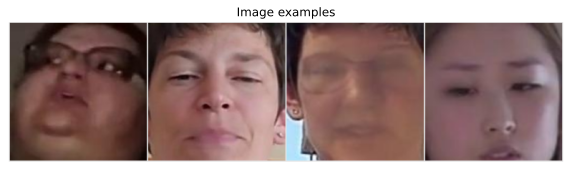

In [ ]:
# Visualize some examples
NUM_IMAGES = 4
images = torch.stack([val_dataset[idx][0] for idx in range(NUM_IMAGES)], dim=0)
img_grid = torchvision.utils.make_grid(images, nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,10))
plt.title("Image examples")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


In [ ]:
def create_model(num_classes):
    # Load a pre-trained ResNet-101 model
    model = models.resnet101(pretrained=True)

    # Freeze the parameters (make them not trainable)
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final layer with a new, trainable layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model

# Create the model
model = create_model(num_classes=2)  # For binary classification


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)  # Optimize only the last layer


In [ ]:
def train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs):
    model.to(device)
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        total = 0

        # Training loop with tqdm progress bar
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', leave=False)
        for i, (inputs, labels) in progress_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == labels).sum().item()
            total += labels.size(0)

            progress_bar.set_postfix(loss=loss.item())

        train_acc = 100 * train_correct / total
        train_avg_loss = train_loss / len(train_loader)
        history['train_loss'].append(train_avg_loss)
        history['train_acc'].append(train_acc)

        # Validation
        val_acc, val_avg_loss = evaluate_model(model, val_loader, criterion)
        history['val_loss'].append(val_avg_loss)
        history['val_acc'].append(val_acc)

        # End of epoch summary
        print(f'End of Epoch: {epoch + 1}, Training Accuracy: {train_acc:.4f}, Average Training Loss: {train_avg_loss:.4f}')
        print(f'Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_avg_loss:.4f}')

    return history

def evaluate_model(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    average_loss = val_loss / len(dataloader)
    return accuracy, average_loss


In [ ]:
num_epochs = 8

res=train_model(model, train_loader, val_loader, optimizer, criterion, num_epochs)

Epoch 1/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 1, Training Accuracy: 86.8143, Average Training Loss: 0.3863
Validation Accuracy: 88.0725, Validation Loss: 0.3375


Epoch 2/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 2, Training Accuracy: 88.0892, Average Training Loss: 0.3339
Validation Accuracy: 87.7705, Validation Loss: 0.3395


Epoch 3/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 3, Training Accuracy: 87.9215, Average Training Loss: 0.3291
Validation Accuracy: 88.2235, Validation Loss: 0.3242


Epoch 4/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 4, Training Accuracy: 88.5254, Average Training Loss: 0.3145
Validation Accuracy: 87.0659, Validation Loss: 0.3391


Epoch 5/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 5, Training Accuracy: 88.5254, Average Training Loss: 0.3155
Validation Accuracy: 88.0725, Validation Loss: 0.3151


Epoch 6/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 6, Training Accuracy: 88.6932, Average Training Loss: 0.3049
Validation Accuracy: 88.0221, Validation Loss: 0.3356


Epoch 7/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 7, Training Accuracy: 88.7267, Average Training Loss: 0.3079
Validation Accuracy: 86.8143, Validation Loss: 0.3518


Epoch 8/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 8, Training Accuracy: 88.4751, Average Training Loss: 0.3161
Validation Accuracy: 88.0725, Validation Loss: 0.3267


In [ ]:
with torch.no_grad():
    number_corrects = 0
    number_samples = 0
    for i, (test_images_set , test_labels_set) in enumerate(test_loader):
        test_images_set = test_images_set.to(device)
        test_labels_set = test_labels_set.to(device)

        y_predicted = model(test_images_set)
        labels_predicted = y_predicted.argmax(axis = 1)
        number_corrects += (labels_predicted==test_labels_set).sum().item()
        number_samples += test_labels_set.size(0)
    print(f'testing dataset testing accuracy {(number_corrects / number_samples)*100}%')

testing dataset testing accuracy 76.78447678447678%


**Resnet 50**

In [ ]:
def create_model_2(num_classes):
    model = models.resnet50(pretrained=True)

    # Freeze the parameters (make them not trainable)
    for param in model.parameters():
        param.requires_grad = False

    # Replace the final layer with a new, trainable layer
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)

    return model

# Create the model
model2 = create_model_2(num_classes=2)  # For binary classification

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model2 = model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)  # Optimize only the last layer

In [ ]:
num_epochs = 8

res=train_model(model2, train_loader, val_loader, optimizer, criterion, num_epochs)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1/8:   0%|          | 0/94 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


End of Epoch: 1, Training Accuracy: 20.6173, Average Training Loss: 0.8385
Validation Accuracy: 21.5903, Validation Loss: 0.8325


Epoch 2/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 2, Training Accuracy: 20.2147, Average Training Loss: 0.8402
Validation Accuracy: 21.2884, Validation Loss: 0.8330


Epoch 3/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 3, Training Accuracy: 19.9128, Average Training Loss: 0.8388
Validation Accuracy: 19.5269, Validation Loss: 0.8446


Epoch 4/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 4, Training Accuracy: 19.8624, Average Training Loss: 0.8401
Validation Accuracy: 19.8792, Validation Loss: 0.8485


Epoch 5/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 5, Training Accuracy: 20.1309, Average Training Loss: 0.8394
Validation Accuracy: 19.8792, Validation Loss: 0.8425


Epoch 6/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 6, Training Accuracy: 19.8289, Average Training Loss: 0.8392
Validation Accuracy: 19.8792, Validation Loss: 0.8481


Epoch 7/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 7, Training Accuracy: 19.9295, Average Training Loss: 0.8397
Validation Accuracy: 19.0237, Validation Loss: 0.8473


Epoch 8/8:   0%|          | 0/94 [00:00<?, ?it/s]

End of Epoch: 8, Training Accuracy: 20.4999, Average Training Loss: 0.8388
Validation Accuracy: 20.0302, Validation Loss: 0.8484


In [ ]:
with torch.no_grad():
    number_corrects = 0
    number_samples = 0
    for i, (test_images_set , test_labels_set) in enumerate(test_loader):
        test_images_set = test_images_set.to(device)
        test_labels_set = test_labels_set.to(device)

        y_predicted = model(test_images_set)
        labels_predicted = y_predicted.argmax(axis = 1)
        number_corrects += (labels_predicted==test_labels_set).sum().item()
        number_samples += test_labels_set.size(0)
    print(f'testing dataset testing accuracy {(number_corrects / number_samples)*100}%')

testing dataset testing accuracy 34.47552447552448%
